# 일원산분석 - 1
## 패키지 설치

In [1]:
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm # 글꼴을 시스템에 등록
import seaborn as sb
from math import sqrt
from hossam import load_data
from scipy.stats import t, normaltest, bartlett, levene, f_oneway, ttest_ind
from statsmodels.stats.anova import anova_lm 
from pingouin import anova, welch_anova
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.formula.api import ols
from pandas import DataFrame, melt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell

## 그래프 초기화

In [2]:
my_dpi = 200
font_path = 'C:\\Users\\wodyd\\Documents\\카카오톡 받은 파일./MaruBuri-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = 'MaruBuri'
my_theme = 'dark'
sb.set_theme(style = my_theme)

plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [3]:
origin = load_data('two_store')
origin.head()

[data] https://data.hossam.kr/data/lab10_/two_store.xlsx
[desc] 동일한 제품을 판매하고 있는 서로 다른 두 지역의 매장의 100일간의 일별 매출액을 기록한 가상의 데이터 (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata


,store1,store2
0,34,63
1,63,85
2,57,75
3,50,48
4,37,58


## 데이터 분포 시각화

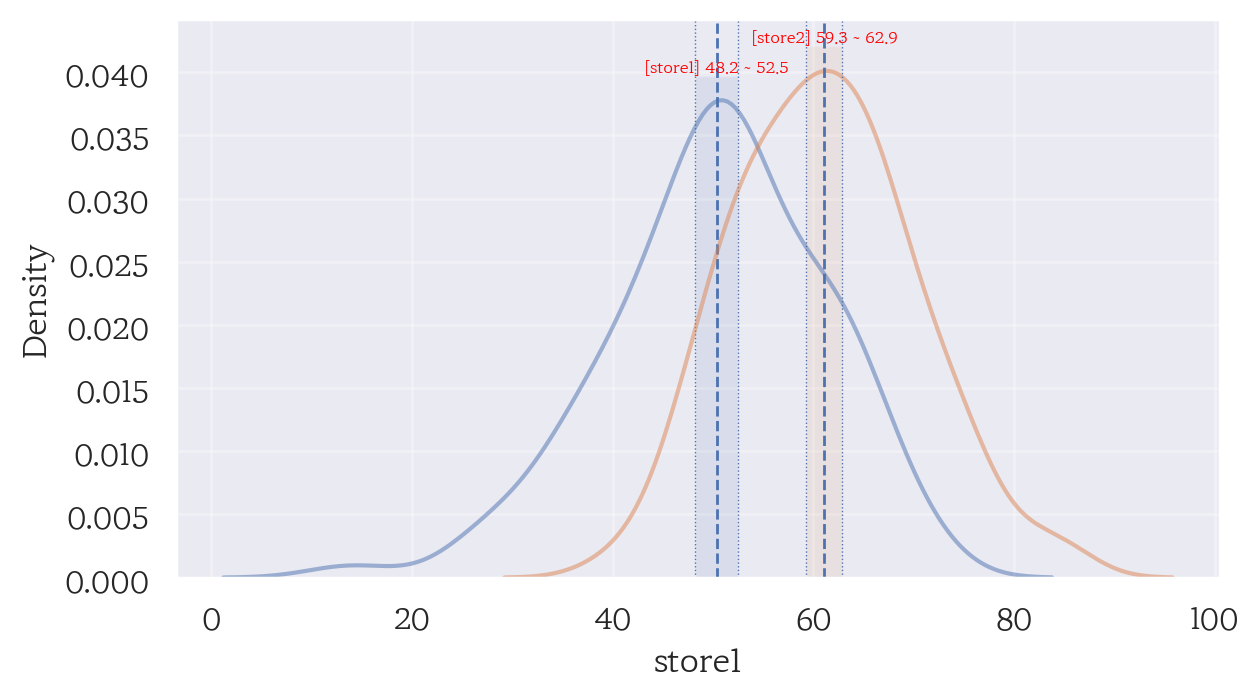

In [4]:
data = origin[['store1','store2']] # 확인할 데이터

# 1) 그래프 초기화
width_px = 1280 # 그래프 가로 크기
height_px = 720 # 그래프 세로 크기
rows = 1 # 그래프 행 수
cols = 1 # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for c in data.columns:
# KDE Plot 그리기
 sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)

# 신뢰구간
 max = data[c].max() # 최대값
 clevel = 0.95 # 신뢰수준
 dof = len(data[c]) - 1 # 자유도
 sp_mean = data[c].mean() # 표본평균
 sp_std = data[c].std(ddof=1) # 표본표준편차
 sp_std_error = sp_std / sqrt(len(data[c])) # 표본표준오차
 cmin, cmax = t.interval(clevel, dof, loc=sp_mean, 
              scale=sp_std_error)
 ax.axvline(cmin, linestyle=':', linewidth=0.5)
 ax.axvline(cmax, linestyle=':', linewidth=0.5)

# 평균 표시
 ymin, ymax = ax.get_ylim()
 ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)
 ax.axvline(sp_mean, linestyle='--', linewidth=1)

# 텍스트 그리기
 ax.text(x=(cmax-cmin)/2+cmin,
         y=ymax,
         s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
         horizontalalignment="center",
         verticalalignment="bottom",
         fontdict={"size": 6, "color": "red"})

# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3) # 배경 격자 표시/숨김

# 4) 출력
plt.tight_layout() # 여백 제거
plt.show() # 그래프 화면 출력
plt.close() # 그래프 작업 종료

## 정규성 검정

In [5]:
data = origin[['store1', 'store2']] # 검사하려는 데이터 추출
equal_var_fields = []
normal_dist = True
report = []
for c in data.columns:
    s, p = normaltest(data[c])
    
    normalize = p > 0.05
    report.append({
         "field": c,
         "statistic": s,
         "p-value": p,
         "result": normalize
    })
    normal_dist = normal_dist and normalize

# 변수가 두 개 이상인 경우 등분산성 확인
if len(data.columns) > 1:
    if normal_dist:
        n = "Bartlett"
# 정규성을 충족할 경우의 검정방법
        s, p = bartlett(*data.values.T) # 모든 컬럼의 데이터를 한번에 전달

    else:
        n = "Levene" # 정규성을 충족하지 않을 경우의 검정방법
        s, p = levene(*data.values.T, center='median') # 모든 컬럼의 데이터를 한번에 전달
   
    report.append({
        "field": n,
        "statistic": s,
        "p-value": p,
        "result": p > 0.05
   })
report_df = DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
store1,5.651229,0.059272,True
store2,1.173772,0.556056,True
Bartlett,3.143307,0.076239,True


## 일원산분석 수행
### scipy 패키지사용

In [6]:
s, p = f_oneway(origin['store1'],origin['store2']) # '제시된 값', alternative = 'less, greater'       # 제시된 값 = t검정에서만 
#'statistic: {0:.3f}, p-value: {1:.3f}, 정규성 충족 여부: {2}'.format(s, p, p > 0.05)
'statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택'.format(s, p, '대립' if p < 0.05 else '귀무')
 
# 등분산성 만족하지 않을 경우 equal_var = False 파라미터 적용하여 Welch - Anova로 전환

'statistic: 58.718, p-value: 0.000, 대립가설 채택'

## statsmodels 패키지 사용
### 데이터 전처리

In [7]:
df = melt(origin, var_name ='store', value_name = 'sales')
df

,store,sales
0,store1,34
1,store1,63
2,store1,57
3,store1,50
4,store1,37
...,...,...
195,store2,69
196,store2,51
197,store2,65
198,store2,59


### 분산분석
- 데이터가 등분산성을 만족하지 않을경우 anova_lm()에 robust = 'hc3' 파라미터 사용하여 Huber-White 추정치 사용
- Welch-Anova 지원 안함

In [8]:
lm = ols('sales ~ C(store)', data = df).fit()
anova_result = anova_lm(lm)
anova_result

,df,sum_sq,mean_sq,F,PR(>F)
C(store),1.0,5735.205,5735.205000,58.717529,7.945482e-13
Residual,198.0,19339.550,97.674495,NaN,NaN


- F 통계량과 p-value 해석
- F = 58 --> 집단 간 차이가 집단 내 변동보다 압도적으로 크다는 의미
- p-value = 7.9 x e-13 --> 0.05보다 훨씬 작음
  ---> 그러므로 귀무가설 기각

### pingouin 패키지 사용
#### 등분산성 만족하는 경우

In [9]:
anova_result = anova(data = df, dv = 'sales', between = 'store')
anova_result

,Source,ddof1,ddof2,F,p-unc,np2
0,store,1,198,58.717529,7.945482e-13,0.228724


#### 등분산성 만족하지 않는 경우

In [10]:
s = anova_result['F'].iloc[0]
p = anova_result['p-unc'].iloc[0]  
'statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택'.format(s, p, '대립' if p < 0.05 else '귀무')

'statistic: 58.718, p-value: 0.000, 대립가설 채택'

## 사후검정 - tuckey HSD
### statsmodels 패키지를 사용하는 경우

In [11]:
tukey = pairwise_tukeyhsd(df['sales'], df['store'])
tukey_table = tukey.summary()
tukey_df = DataFrame(tukey_table.data[1:],
            columns = tukey_table.data[0])
tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,store1,store2,10.71,0.0,7.9538,13.4662,True


### pingouin 패키지 사용하는 경우

In [12]:
tukey_df = pairwise_tukey(data = df, dv = 'sales', between = 'store')
tukey_df

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,store1,store2,50.36,61.07,-10.71,1.397673,-7.662736,8.714141e-13,-1.079565


### 본페로니 교정
- tukeyhsd 보다 보수적이어서 실무에서는 잘 사용되지 않는다
- 2종오류의 위험성이 높다

#### statsmodels 패키지를 사용하는 경우

In [13]:
comp = MultiComparison(df['sales'], df['store'])
result = comp.allpairtest(ttest_ind, method = 'bonf')
bonf_df = DataFrame(result[0].data[1:], columns = result[0].data[0])
bonf_df

,group1,group2,stat,pval,pval_corr,reject
0,store1,store2,-7.6627,0.0,0.0,True


#### pingouin 패키지를 사용하는 경우

In [14]:
bonf_df = pairwise_tests(data = df, dv = 'sales', between = 'store')
bonf_df

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,store,store1,store2,False,True,-7.662736,198.0,two-sided,7.945482e-13,8.14e+09,-1.079565


### Games-Howell 검정
- 다수의 그룹 간의 평균 차이를 비교, 등분산성 가정이 만족되지 않을 때 사용된다

In [15]:
gh_df = pairwise_gameshowell(df, dv = 'sales', between = 'store')
gh_df

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,store1,store2,50.36,61.07,-10.71,1.397673,-7.662736,192.521085,9.281464e-13,-1.079565


# 일원산분석 - 2
## 그래프 초기화

In [16]:
my_dpi = 200
font_path = 'C:\\Users\\wodyd\\Documents\\카카오톡 받은 파일./MaruBuri-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = 'MaruBuri'
my_theme = 'dark'
sb.set_theme(style = my_theme)

plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [17]:
origin = load_data('tips')
origin.head()
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(f'==' * 25)
origin.info()

[data] https://data.hossam.kr/data/kaggle/tips.xlsx
[desc] 식당 고객의 결제 금액, 팁, 성별, 흡연 여부, 요일, 시간대, 일행 규모 등 기본 정보를 담은 데이터 분석·시각화 실습용 샘플 데이터 (출처: https://www.kaggle.com/datasets/sakshisatre/tips-dataset)

field       description
----------  -------------
total_bill  총 결제 금액
tip         팁 금액
sex         성별
smoker      흡연 여부
day         방문 요일
time        방문 시간대
size        일행 규모

데이터셋 크기: (244, 7)
열 개수: 7
행 개수: 244
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


## 데이터 전처리 - 특정 요일 데이터만 추출

In [18]:
df = origin[(origin['day'] == 'Fri') | (origin['day'] =='Sat') | (origin['day'] == 'Sun')]
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


## 데이터 분포 및 가정 확인

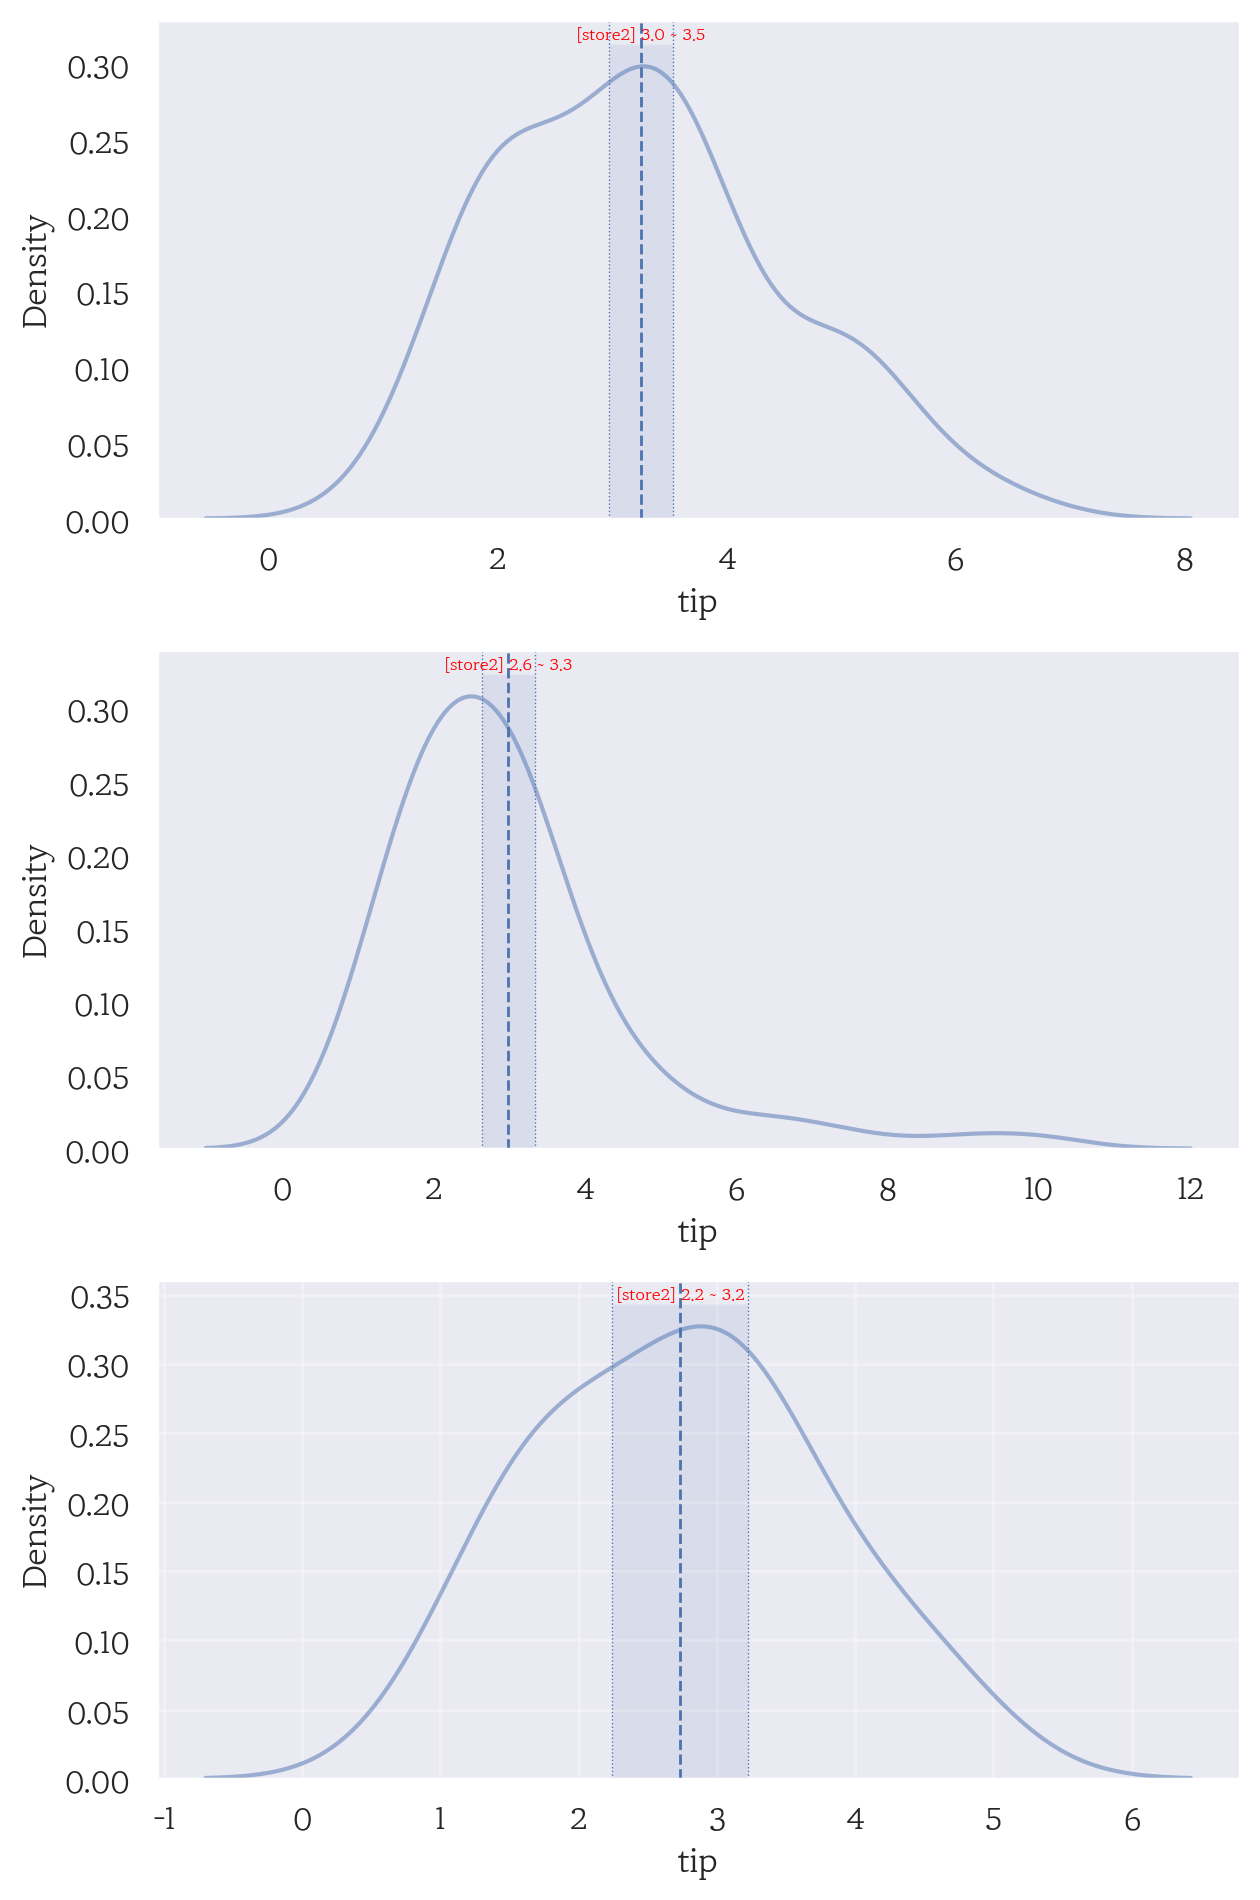

In [ ]:
# 확인할 데이터 필드
field = 'tip'

# 집단을 구분하는 필드
hue_field = 'day'

# 요일 종류 구하기
hue_values = df[hue_field].unique()

hue_count = len(hue_values)

# 1) 그래프 초기화
width_px = 1280 # 그래프 가로 크기
height_px = 640 * 3 # 그래프 세로 크기
rows = 3 # 그래프 행 수
cols = 1 # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for i, v in enumerate(hue_values):
 temp = df[df[hue_field] == v]

# KDE Plot 그리기
 sb.kdeplot(data = temp, x=field, fill=False, alpha=0.5, ax =ax[i])

# 신뢰구간
 max = temp[field].max() # 최대값
 clevel = 0.95 # 신뢰수준
 dof = len(temp[field]) - 1 # 자유도
 sp_mean = temp[field].mean() # 표본평균
 sp_std = temp[field].std(ddof=1) # 표본표준편차
 sp_std_error = sp_std / sqrt(len(temp[field])) # 표본표준오차
 cmin, cmax = t.interval(clevel, dof, loc=sp_mean, 
              scale=sp_std_error)
 ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
 ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

# 평균 표시
 ymin, ymax = ax[i].get_ylim()
 ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
 ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

# 텍스트 그리기
 ax[i].text(x=(cmax-cmin)/2+cmin,
         y=ymax,
         s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
         horizontalalignment="center",
         verticalalignment="bottom",
         fontdict={"size": 6, "color": "red"})

# 3) 그래프 꾸미기
ax[i].grid(True, alpha=0.3) # 배경 격자 표시/숨김

# 4) 출력
plt.tight_layout() # 여백 제거
plt.show() # 그래프 화면 출력
plt.close() # 그래프 작업 종료

## 정규성 및 등분산성 검정

In [ ]:
# 요일별 그룹 생성
groups = [(name, grp['tip']) for name, grp in df.groupby('day')]

report = []
normal_dist = True # 정규성 만족 여부
for name, series in groups:
 stat, p = normaltest(series)
 ok = p>0.05
 report.append({'field':name, 'statistic': stat, 'p-value': p, 'result': ok})
 normal_dist = normal_dist and ok

# 등분산성 검정 선택
if normal_dist:
 test_name = "Bartlett"
 stat, p = bartlett(*[s.values for _, s in groups])
else:
 test_name = "Levene"
 stat, p = levene(*[s.values for _, s in groups], center = 'median')

equal_var = p> 0.05
report.append({'field':test_name, 'statistic': stat, 'p-value': p, 'result': equal_var})

report_df = DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
Fri,0.416676,8.119325e-01,True
Sat,49.144308,2.130341e-11,False
Sun,3.396232,1.830280e-01,True
Levene,0.651391,5.225516e-01,True


## 일원산분석 수행
### 분석에 필요한 데이터 추출

In [21]:
anova_df = origin[['tip','day']].copy()
anova_df

,tip,day
0,1.01,Sun
1,1.66,Sun
2,3.50,Sun
3,3.31,Sun
4,3.61,Sun
...,...,...
239,5.92,Sat
240,2.00,Sat
241,2.00,Sat
242,1.75,Sat


### pingouin 패키지 사용

In [22]:
if equal_var:
    pg_anova = anova(data = anova_df, dv = 'tip', between ='day')
else:
    pg_anova = welch_anova(data = anova_df, dv = 'tip', between = 'day')
pg_anova

,Source,ddof1,ddof2,F,p-unc,np2
0,day,3,240,1.672355,0.173589,0.020476


### 가설 검정

In [23]:
f_val = pg_anova['F'].iloc[0]
p_val = pg_anova['p-unc'].iloc[0] 
'statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택'.format(f_val, p_val, '대립' if p_val < 0.05 else '귀무')

'statistic: 1.672, p-value: 0.174, 귀무가설 채택'

### 사후검정

In [24]:
if equal_var:
    print('== Tukey HSD ==')
    hoc_df = pairwise_tukey(data = anova_df, dv = 'tip', between = 'day')
else:
    print('== Games-Howell ==')
    hoc_df = pairwise_gameshowell(data = anova_df, dv = 'tip', between = 'day')

hoc_df 

== Tukey HSD ==


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Fri,Sat,2.734737,2.993103,-0.258367,0.348935,-0.740444,0.880645,-0.166274
1,Fri,Sun,2.734737,3.255132,-0.520395,0.353432,-1.472405,0.455805,-0.431509
2,Fri,Thur,2.734737,2.771452,-0.036715,0.361324,-0.101612,0.999623,-0.030468
3,Sat,Sun,2.993103,3.255132,-0.262028,0.216349,-1.211136,0.620382,-0.178644
4,Sat,Thur,2.993103,2.771452,0.221652,0.229016,0.967846,0.767858,0.148857
5,Sun,Thur,3.255132,2.771452,0.483680,0.235811,2.051132,0.172421,0.388762


## 연습문제 - 1    

In [33]:
origin = load_data('tree_weight')
origin.head()
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
origin
df1 = origin.copy()

[data] https://data.hossam.kr/data/lab10_/tree_weight.xlsx
[desc] 소나무 품종별 무게를 조사한 데이터 (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata
데이터셋 크기: (30, 2)
열 개수: 2
행 개수: 30


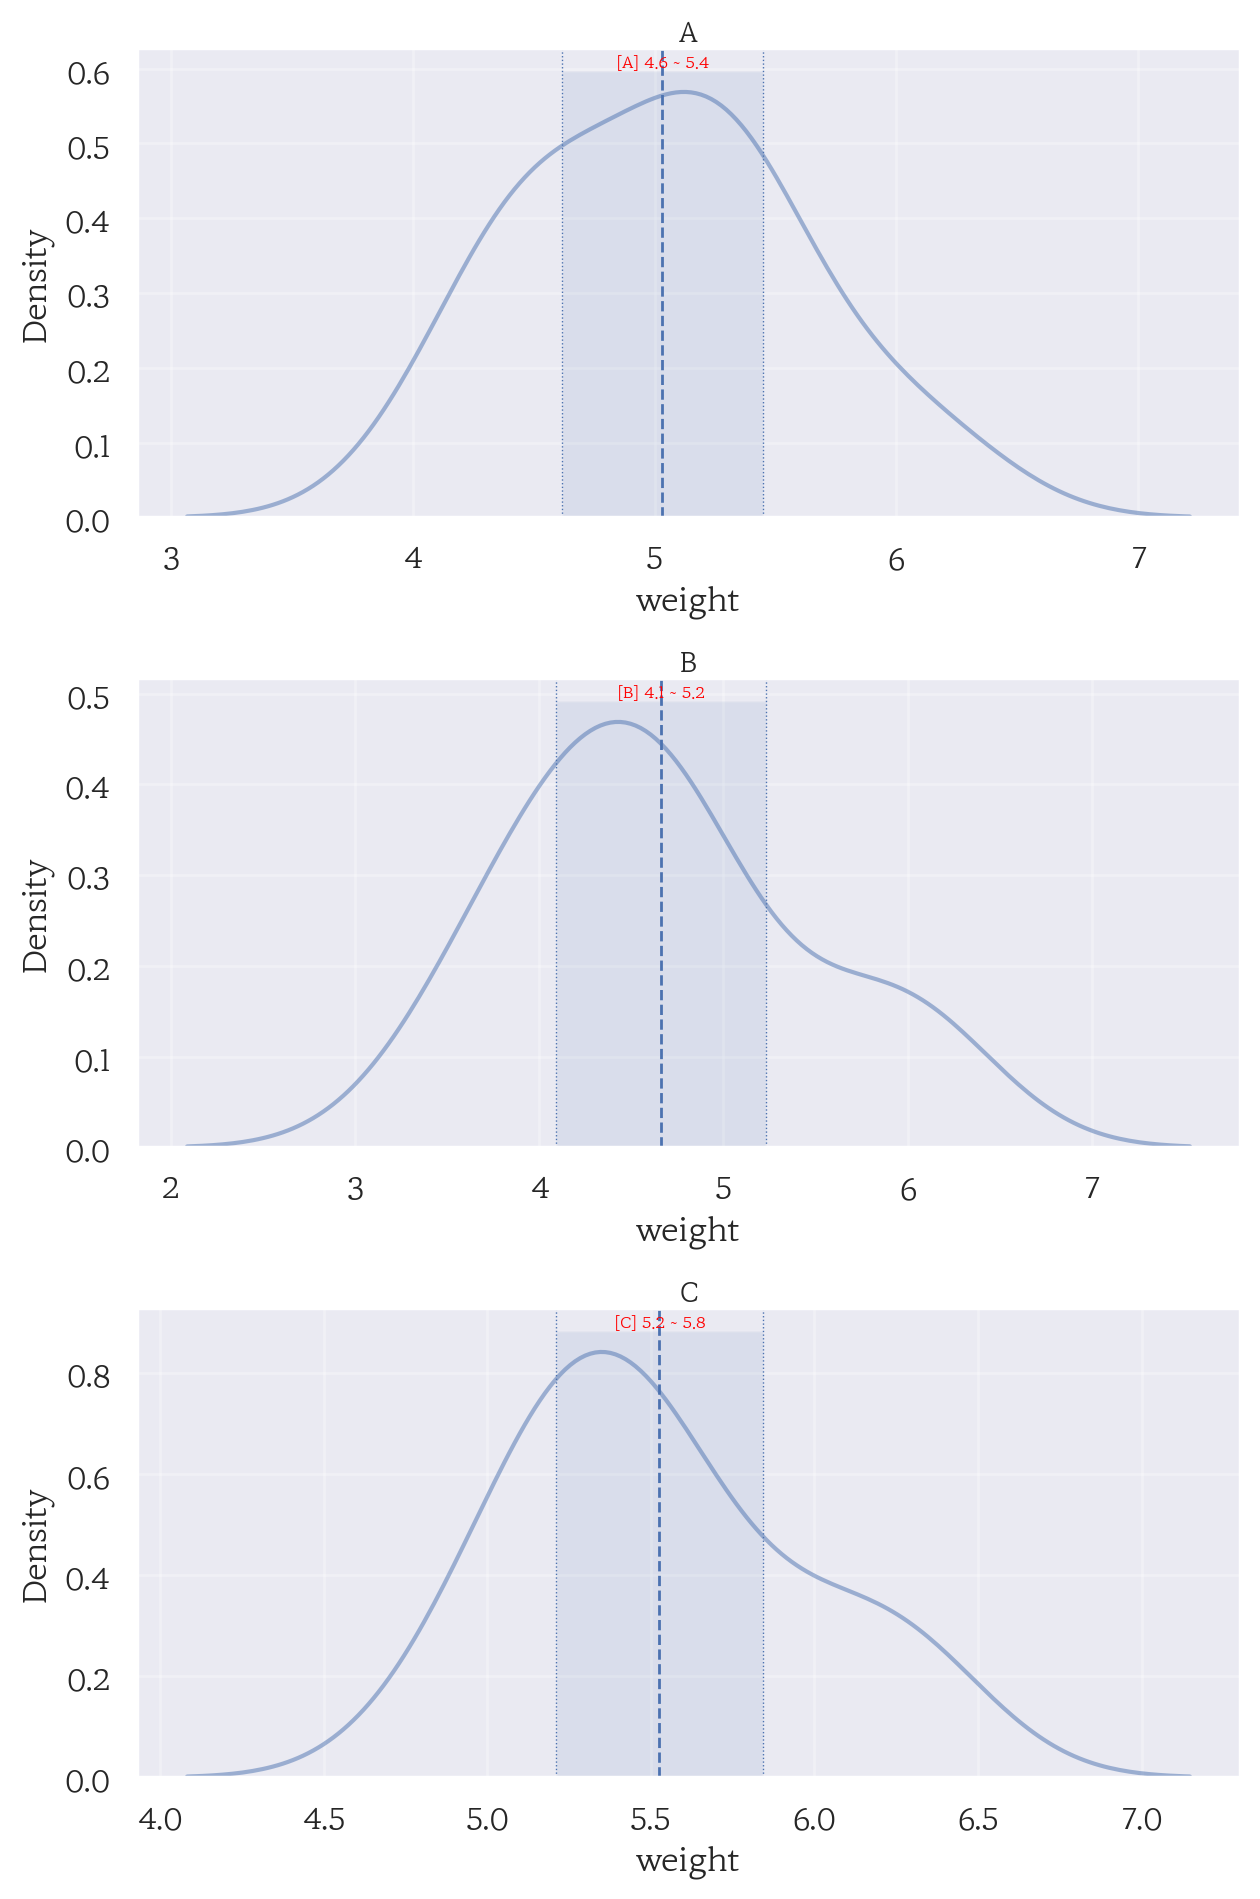

In [ ]:
# 확인할 데이터 필드
field = 'weight'

# 집단을 구분하는 필드
hue_field = 'group'

# 요일 종류 구하기
hue_values = df1[hue_field].unique()

hue_count = len(hue_values)

# 1) 그래프 초기화
width_px = 1280 # 그래프 가로 크기
height_px = 640 * 3 # 그래프 세로 크기, * rows
rows = 3 # 그래프 행 수
cols = 1 # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for i, v in enumerate(hue_values):
 temp = df1[df1[hue_field] == v]

# KDE Plot 그리기
 sb.kdeplot(data = temp, x=field, fill=False, alpha=0.5, ax =ax[i])
 ax[i].grid(True, alpha = 0.3)
 ax[i].set_title(v, fontsize = 10, pad = 3)

# 신뢰구간
 max = temp[field].max() # 최대값
 clevel = 0.95 # 신뢰수준
 dof = len(temp[field]) - 1 # 자유도
 sp_mean = temp[field].mean() # 표본평균
 sp_std = temp[field].std(ddof=1) # 표본표준편차
 sp_std_error = sp_std / sqrt(len(temp[field])) # 표본표준오차
 cmin, cmax = t.interval(clevel, dof, loc=sp_mean, 
              scale=sp_std_error)
 ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
 ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

# 평균 표시
 ymin, ymax = ax[i].get_ylim()
 ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
 ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

# 텍스트 그리기
 ax[i].text(x=(cmax-cmin)/2+cmin,
         y=ymax,
         s="[%s] %0.1f ~ %0.1f" % (v, cmin, cmax),
         horizontalalignment="center",
         verticalalignment="bottom",
         fontdict={"size": 6, "color": "red"})

# 4) 출력
plt.tight_layout() # 여백 제거
plt.show() # 그래프 화면 출력
plt.close() # 그래프 작업 종료

In [37]:
# 요일별 그룹 생성
groups = [(name, grp['weight']) for name, grp in df1.groupby('group')]

report = []
normal_dist = True # 정규성 만족 여부
for name, series in groups:
 stat, p = normaltest(series)
 ok = p>0.05
 report.append({'field':name, 'statistic': stat, 'p-value': p, 'result': ok})
 normal_dist = normal_dist and ok

# 등분산성 검정 선택
if normal_dist:
 test_name = "Bartlett"
 stat, p = bartlett(*[s.values for _, s in groups])
else:
 test_name = "Levene"
 stat, p = levene(*[s.values for _, s in groups], center = 'median')

equal_var = p> 0.05
report.append({'field':test_name, 'statistic': stat, 'p-value': p, 'result': equal_var})

report_df = DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
A,0.233496,0.889810,True
B,0.967741,0.616393,True
C,1.013177,0.602548,True
Bartlett,2.878574,0.237097,True


In [51]:
if equal_var:
    pg_anova = anova(data = df1, dv = 'weight', between = 'group')
else:
    pg_anova = welch_anova(data = df1, dv = 'weight', between = 'group')

pg_anova

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,27,4.846088,0.01591,0.264148


In [53]:
f_val = pg_anova['F'].iloc[0]
p_val = pg_anova['p-unc'].iloc[0]
'statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택'.format(f_val, p_val, '대립' if p_val < 0.05 else '귀무')

'statistic: 4.846, p-value: 0.016, 대립가설 채택'

In [54]:
if equal_var:
    print('== Tukey HSD ==')
    hoc_df = pairwise_tukey(data = df1, dv = 'weight', between = 'group')
else:
    print('== Games-Howell ==')
    hoc_df = pairwise_gameshowell(data = df1, dv = 'weight', between = 'group')

hoc_df 

== Tukey HSD ==


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,5.032,4.661,0.371,0.278782,1.330791,0.390871,0.510237
1,A,C,5.032,5.526,-0.494,0.278782,-1.771996,0.197996,-0.914038
2,B,C,4.661,5.526,-0.865,0.278782,-3.102787,0.012006,-1.289277


- B와 C에서만 유의미한 차이가 있다. 

## 연습문제 - 2

## 연습문제 - 3

In [47]:
origin = load_data('commercial')
origin.head()
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
origin.info()

[data] https://data.hossam.kr/data/lab10_/commercial.xlsx
[desc] 서울시의 2023년 상권에 따른 분기별 매출액과 매출건수에 대한 자료 (출처: 서울 열린데이터 광장)
[!] Cannot read metadata
데이터셋 크기: (6222, 6)
열 개수: 6
행 개수: 6222
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6222 entries, 0 to 6221
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   quarter          6222 non-null   int64 
 1   code             6222 non-null   int64 
 2   type             6222 non-null   object
 3   name             6222 non-null   object
 4   sales_amount     6222 non-null   int64 
 5   number_of_sales  6222 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 291.8+ KB


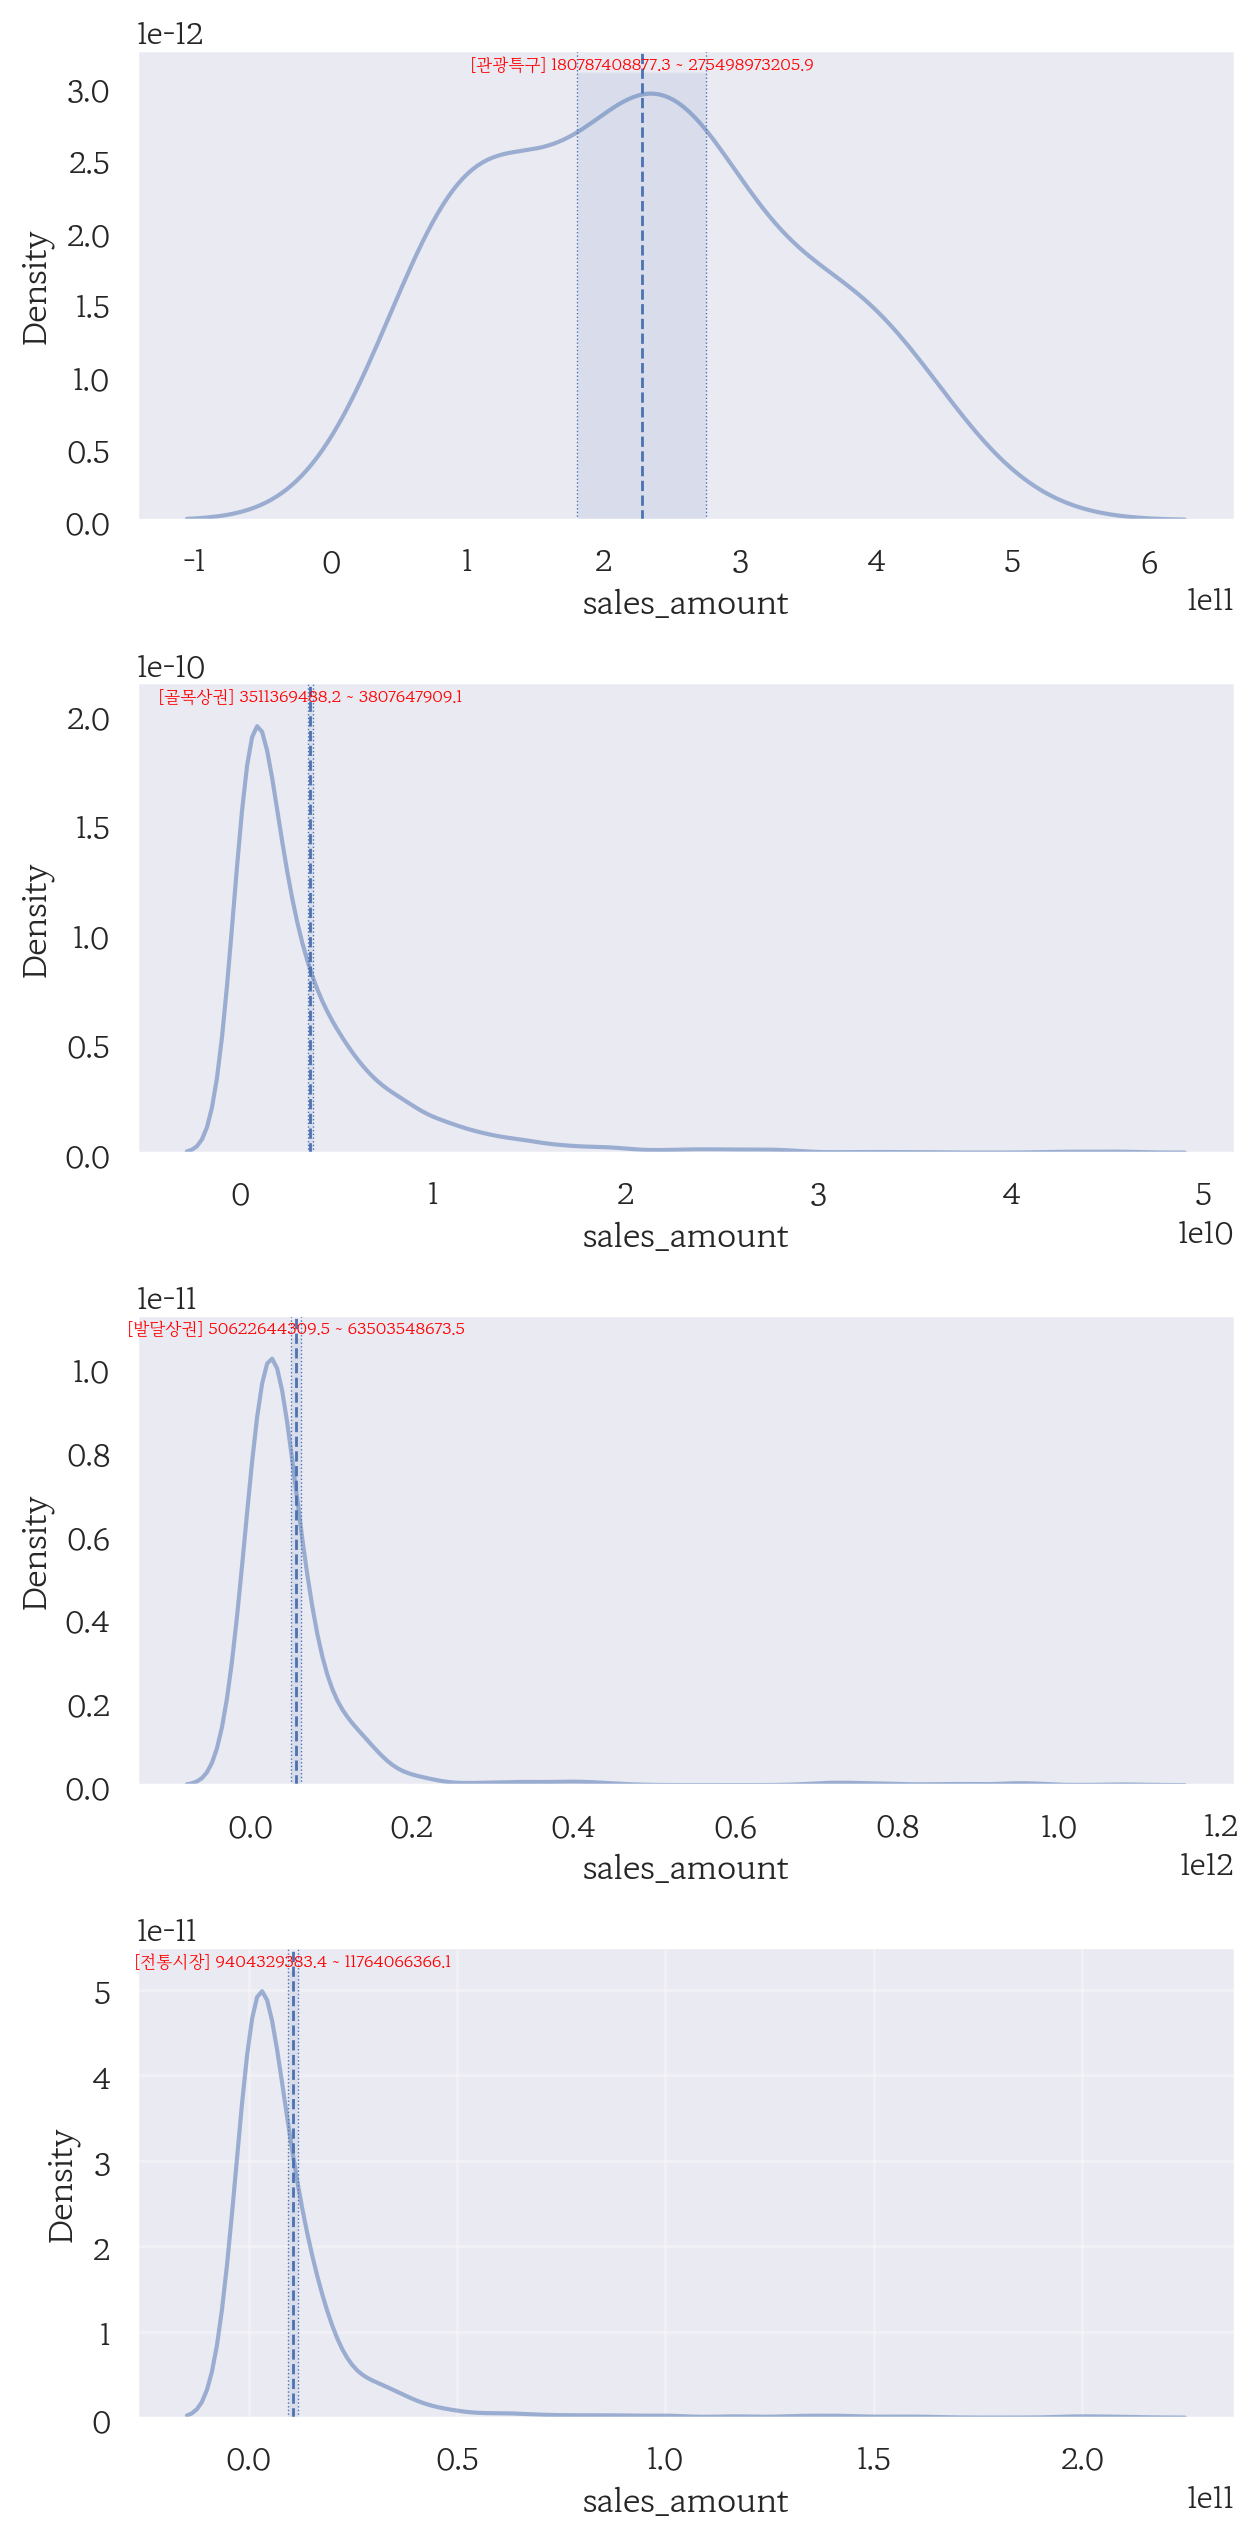

In [50]:
# 확인할 데이터 필드
field = 'sales_amount'

# 집단을 구분하는 필드
hue_field = 'type'

# 요일 종류 구하기
hue_values = origin[hue_field].unique()

hue_count = len(hue_values)

# 1) 그래프 초기화
width_px = 1280 # 그래프 가로 크기
height_px = 640 * 4 # 그래프 세로 크기
rows = 4 # 그래프 행 수
cols = 1 # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for i, v in enumerate(hue_values):
 temp = origin[origin[hue_field] == v]

# KDE Plot 그리기
 sb.kdeplot(data = temp, x=field, fill=False, alpha=0.5, ax =ax[i])

# 신뢰구간
 max = temp[field].max() # 최대값
 clevel = 0.95 # 신뢰수준
 dof = len(temp[field]) - 1 # 자유도
 sp_mean = temp[field].mean() # 표본평균
 sp_std = temp[field].std(ddof=1) # 표본표준편차
 sp_std_error = sp_std / sqrt(len(temp[field])) # 표본표준오차
 cmin, cmax = t.interval(clevel, dof, loc=sp_mean, 
              scale=sp_std_error)
 ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
 ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

# 평균 표시
 ymin, ymax = ax[i].get_ylim()
 ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
 ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

# 텍스트 그리기
 ax[i].text(x=(cmax-cmin)/2+cmin,
         y=ymax,
         s="[%s] %0.1f ~ %0.1f" % (v, cmin, cmax),
         horizontalalignment="center",
         verticalalignment="bottom",
         fontdict={"size": 6, "color": "red"})

# 3) 그래프 꾸미기
ax[i].grid(True, alpha=0.3) # 배경 격자 표시/숨김

# 4) 출력
plt.tight_layout() # 여백 제거
plt.show() # 그래프 화면 출력
plt.close() # 그래프 작업 종료